In [ ]:
!pip install -qq transformers 

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 38.3 MB/s 
     |████████████████████████████████| 596 kB 52.1 MB/s 
     |████████████████████████████████| 61 kB 480 kB/s 
     |████████████████████████████████| 895 kB 46.5 MB/s 


In [5]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
sns.set(font_scale =1.25)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
df = pd .read_csv('/content/drive/MyDrive/Google_play_reviews_sentiment_analysis/Data/reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOFnERazHG7XwV8F0wcRC-vxSg2Qq8C8FrL1Mwm...,Scot Loggan,https://play-lh.googleusercontent.com/a-/AOh14...,This zoom app won't let me use my phone while ...,1,7,5.8.6.3139,2021-12-21 00:02:44,NaN,NaN,most_relevant,us.zoom.videomeetings
1,gp:AOqpTOEipEUWphaQC3txgZfyyNNxL0yz5PkMEznW1pw...,Dorian Elston,https://play-lh.googleusercontent.com/a/AATXAJ...,I dislike that others can seize the functions ...,1,12,5.8.6.3139,2021-12-16 03:29:39,NaN,NaN,most_relevant,us.zoom.videomeetings
2,gp:AOqpTOEEcIn6G873SQFu2V4sf1zd38DLsSF7KyNVa1v...,Daniel Vargas,https://play-lh.googleusercontent.com/a-/AOh14...,Locking portrait on phone settings does not wo...,1,4,5.8.6.3139,2021-12-21 02:26:32,NaN,NaN,most_relevant,us.zoom.videomeetings
3,gp:AOqpTOEj9flcSys5iBXkN2WAIZ17YaRxyT8wJTtmcIN...,Jackie Golds,https://play-lh.googleusercontent.com/a/AATXAJ...,I tried to do a zoom court meeting today and w...,1,16,5.8.6.3139,2021-12-08 19:20:37,NaN,NaN,most_relevant,us.zoom.videomeetings
4,gp:AOqpTOHTErqR2x3PFMM4sjYwA9uFDE-iMpDmhcBcc8q...,Frank Smo,https://play-lh.googleusercontent.com/a/AATXAJ...,Can never hear. I'm using on a galaxy S8 and v...,1,13,5.8.6.3139,2021-12-05 23:24:52,NaN,NaN,most_relevant,us.zoom.videomeetings


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40546 entries, 0 to 40545
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              40546 non-null  object
 1   userName              40546 non-null  object
 2   userImage             40546 non-null  object
 3   content               40518 non-null  object
 4   score                 40546 non-null  int64 
 5   thumbsUpCount         40546 non-null  int64 
 6   reviewCreatedVersion  33389 non-null  object
 7   at                    40546 non-null  object
 8   replyContent          7943 non-null   object
 9   repliedAt             7943 non-null   object
 10  sortOrder             40546 non-null  object
 11  appId                 40546 non-null  object
dtypes: int64(2), object(10)
memory usage: 3.7+ MB


In [ ]:
df.isnull().sum()

reviewId                    0
userName                    0
userImage                   0
content                    28
score                       0
thumbsUpCount               0
reviewCreatedVersion     7157
at                          0
replyContent            32603
repliedAt               32603
sortOrder                   0
appId                       0
dtype: int64

In [7]:
df = df.dropna(subset=['content'])

In [ ]:
df.isnull().sum()

reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion     7138
at                          0
replyContent            32575
repliedAt               32575
sortOrder                   0
appId                       0
dtype: int64

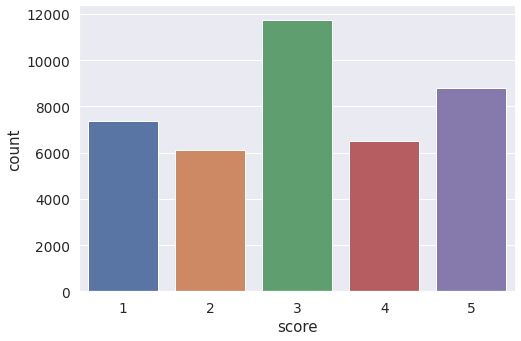

In [8]:
ax=sns.catplot(x="score", data=df, kind="count", height=5, aspect=1.5);

In [9]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

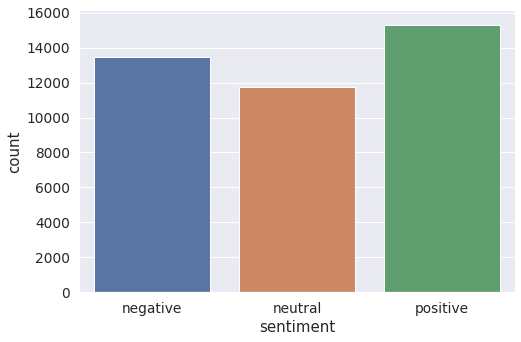

In [ ]:
ax = sns.catplot(x="sentiment", data=df, kind="count", height=5, aspect=1.5);
ax.set_xticklabels(class_names);

In [10]:
# Word cloud 
def wordCloud(sentiment):
    data = df[df['sentiment'] == sentiment]
    text = " ".join(review for review in data.content)
    wordcloud = WordCloud(background_color='black',height = 600, width = 800).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

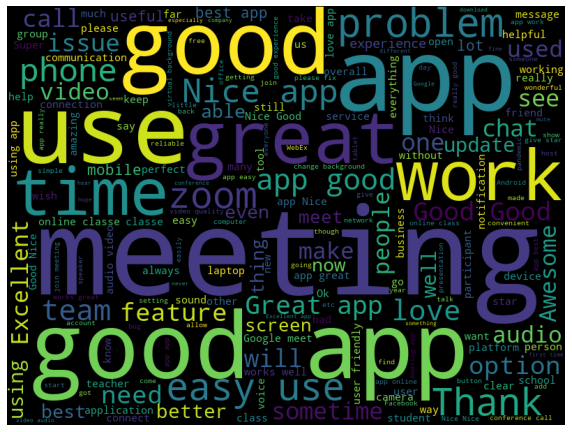

In [11]:
# most positive words
wordCloud(2)

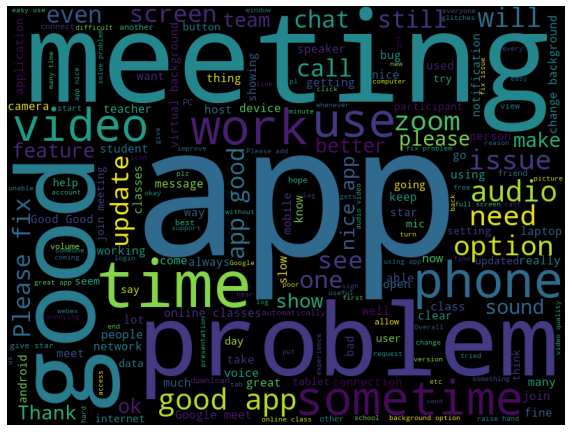

In [12]:
# most neutral words
wordCloud(1)

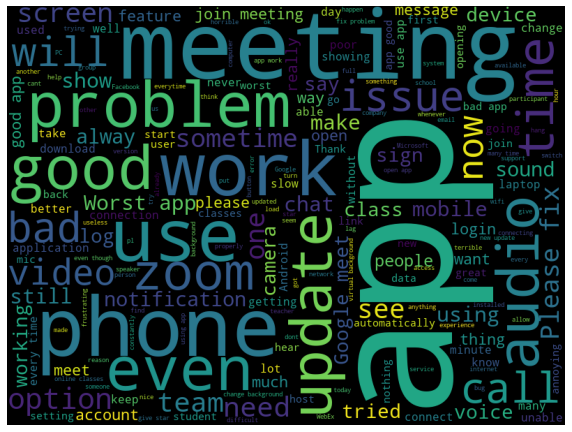

In [13]:
# most negative words
wordCloud(0)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sample_txt = 'Everytime I log in ... The app throw me out and say "your session has ended please log in again" I logged in for 5 times in row . I used this app for 2 years and this the first time to face this problem .'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Everytime I log in ... The app throw me out and say "your session has ended please log in again" I logged in for 5 times in row . I used this app for 2 years and this the first time to face this problem .
   Tokens: ['every', '##time', 'i', 'log', 'in', '.', '.', '.', 'the', 'app', 'throw', 'me', 'out', 'and', 'say', '"', 'your', 'session', 'has', 'ended', 'please', 'log', 'in', 'again', '"', 'i', 'logged', 'in', 'for', '5', 'times', 'in', 'row', '.', 'i', 'used', 'this', 'app', 'for', '2', 'years', 'and', 'this', 'the', 'first', 'time', 'to', 'face', 'this', 'problem', '.']
Token IDs: [2296, 7292, 1045, 8833, 1999, 1012, 1012, 1012, 1996, 10439, 5466, 2033, 2041, 1998, 2360, 1000, 2115, 5219, 2038, 3092, 3531, 8833, 1999, 2153, 1000, 1045, 26618, 1999, 2005, 1019, 2335, 1999, 5216, 1012, 1045, 2109, 2023, 10439, 2005, 1016, 2086, 1998, 2023, 1996, 2034, 2051, 2000, 2227, 2023, 3291, 1012]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=80,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

80


tensor([  101,  2296,  7292,  1045,  8833,  1999,  1012,  1012,  1012,  1996,
        10439,  5466,  2033,  2041,  1998,  2360,  1000,  2115,  5219,  2038,
         3092,  3531,  8833,  1999,  2153,  1000,  1045, 26618,  1999,  2005,
         1019,  2335,  1999,  5216,  1012,  1045,  2109,  2023, 10439,  2005,
         1016,  2086,  1998,  2023,  1996,  2034,  2051,  2000,  2227,  2023,
         3291,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

80


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'every',
 '##time',
 'i',
 'log',
 'in',
 '.',
 '.',
 '.',
 'the',
 'app',
 'throw',
 'me',
 'out',
 'and',
 'say',
 '"',
 'your',
 'session',
 'has',
 'ended',
 'please',
 'log',
 'in',
 'again',
 '"',
 'i',
 'logged',
 'in',
 'for',
 '5',
 'times',
 'in',
 'row',
 '.',
 'i',
 'used',
 'this',
 'app',
 'for',
 '2',
 'years',
 'and',
 'this',
 'the',
 'first',
 'time',
 'to',
 'face',
 'this',
 'problem',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

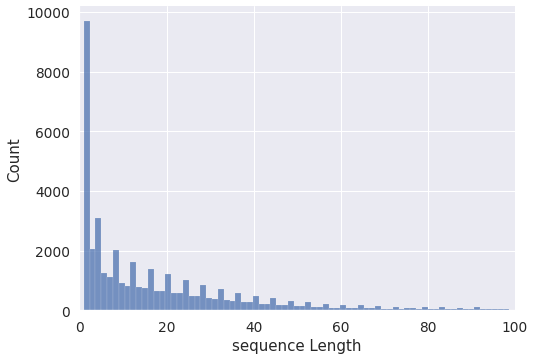

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df.content]
ax = sns.displot(seq_len, height=5, aspect=1.5);
ax.set_xlabels('sequence Length');
ax.set(xlim=(0,100));

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
df1 = df[['content','sentiment']]
df1 = df1.rename(columns={'content':'review'})

In [ ]:
# Train , val and test data 

train, test = train_test_split(df1, test_size=0.1, random_state=RANDOM_SEED, stratify=df1.sentiment.values)
val, test = train_test_split(test, test_size=0.5, random_state=RANDOM_SEED, stratify=test.sentiment.values)

In [ ]:
# save the data

# train.to_csv('/content/drive/MyDrive/Google_play_reviews_sentiment_analysis/Data/train.csv',index=False)
# val.to_csv('/content/drive/MyDrive/Google_play_reviews_sentiment_analysis/Data/validation.csv', index=False)
# test.to_csv('/content/drive/MyDrive/Google_play_reviews_sentiment_analysis/Data/test.csv',index=False)

In [ ]:
# Load the data 
train = pd.read_csv('/content/drive/MyDrive/Google_play_reviews_sentiment_analysis/Data/train.csv')
val = pd.read_csv('/content/drive/MyDrive/Google_play_reviews_sentiment_analysis/Data/validation.csv')
test = pd.read_csv('/content/drive/MyDrive/Google_play_reviews_sentiment_analysis/Data/test.csv')

In [ ]:
train.shape, val.shape, test.shape

((36466, 2), (2026, 2), (2026, 2))

In [ ]:
## DataLoader
BATCH_SIZE = 32
MAX_LEN = 60

train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 60])
torch.Size([32, 60])
torch.Size([32])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors
)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    #Freeze bert layers
    # if freeze_bert:
    #   for p in self.bert.parameters():
    #       p.requires_grad = False
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))


model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 60])
torch.Size([32, 60])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2845, 0.2247, 0.4908],
        [0.2711, 0.2362, 0.4927],
        [0.2674, 0.3630, 0.3696],
        [0.2451, 0.3236, 0.4313],
        [0.2543, 0.3589, 0.3868],
        [0.3687, 0.2408, 0.3904],
        [0.2308, 0.2551, 0.5141],
        [0.1634, 0.2724, 0.5642],
        [0.2742, 0.3803, 0.3456],
        [0.4160, 0.2880, 0.2960],
        [0.1883, 0.1749, 0.6368],
        [0.5703, 0.1312, 0.2985],
        [0.2933, 0.4077, 0.2990],
        [0.2919, 0.4184, 0.2897],
        [0.2635, 0.3343, 0.4022],
        [0.3267, 0.3942, 0.2792],
        [0.2781, 0.2036, 0.5183],
        [0.3793, 0.2435, 0.3772],
        [0.1368, 0.5219, 0.3413],
        [0.2800, 0.2530, 0.4670],
        [0.3246, 0.3595, 0.3159],
        [0.3074, 0.2478, 0.4448],
        [0.2523, 0.2692, 0.4784],
        [0.2744, 0.4413, 0.2843],
        [0.2019, 0.2998, 0.4983],
        [0.2949, 0.2999, 0.4052],
        [0.3795, 0.2664, 0.3541],
        [0.2679, 0.3899, 0.3423],
        [0.3199, 0.3141, 0.3659],
        [0.268

In [ ]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=.01, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  i=0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.8296178524170006 accuracy 0.6224976690615917
Val   loss 0.7464140923693776 accuracy 0.6668311944718657

Epoch 2/4
----------
Train loss 0.6353758487915784 accuracy 0.7353973564416169
Val   loss 0.7077576396986842 accuracy 0.702862783810464

Epoch 3/4
----------
Train loss 0.4508616898993128 accuracy 0.8273734437558273
Val   loss 0.7428961358964443 accuracy 0.7309970384995064

Epoch 4/4
----------
Train loss 0.3412153007626011 accuracy 0.8748423188723743
Val   loss 0.8411004249937832 accuracy 0.7329713721618953

CPU times: user 48min 18s, sys: 18min 19s, total: 1h 6min 38s
Wall time: 1h 6min 39s


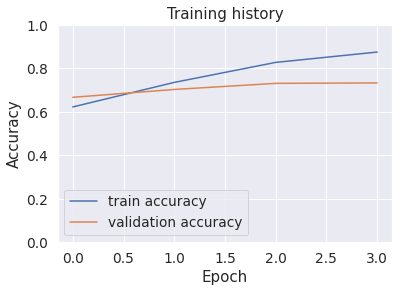

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
mod = SentimentClassifier(len(class_names))
mod.load_state_dict(torch.load('/content/best_model'))
mod = mod.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
test_acc, _ = eval_model(
  mod,
  test_data_loader,
  loss_fn,
  device,
  len(test)
)

test_acc.item()

0.7561697926949654

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  mod,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.81      0.80      0.80       674
     neutral       0.68      0.58      0.63       587
    positive       0.76      0.85      0.80       765

    accuracy                           0.76      2026
   macro avg       0.75      0.74      0.74      2026
weighted avg       0.75      0.76      0.75      2026



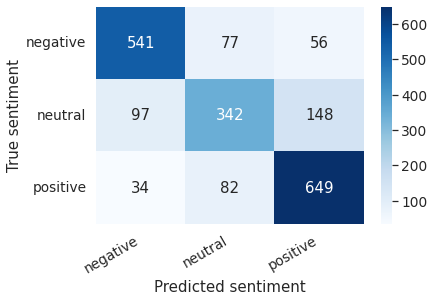

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 50

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Once I got on it was very good, but the application have me a hard
time getting on with my laptop, finally got on with smart phone, so I
missed a few minutes of the meeting

True sentiment: positive


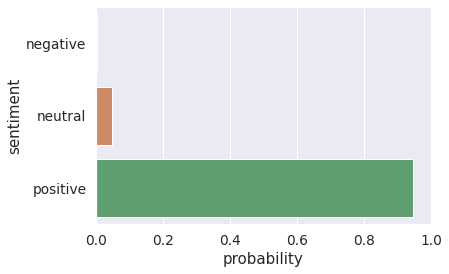

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
review_text = "I hate This meeting app!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I hate This meeting app!
Sentiment  : negative
